# Objectives
Whether you're looking to impress your friends by showing them when and where the **International Space Station** 🛰️ will pass overhead, or you need to verify if an **interplanetary probe** will be above a certain **elevation** for radio antenna communication 📡, this example has you covered. In this notebook, we'll demonstrate how to use **Tudatpy** to generate **visibility plots (azimuth and elevation)** for a specific target, from a selected location on Earth, across a given time period. In order to validate our results, we will compare them with results from the [JPL Horizons tool](https://ssd.jpl.nasa.gov/horizons/app.html#/). 

## Import Relevant Modules
Let's start by importing all relevant modules and libraries. Notably, we will need the [HorizonsQuery class](https://py.api.tudat.space/en/latest/horizons.html#tudatpy.data.horizons.HorizonsQuery), containing wrapper function to the [JPL Horizons tool](https://ssd.jpl.nasa.gov/horizons/app.html#/). We will also make use of Tudat's interface to the NASA's [spice tool](https://py.api.tudat.space/en/latest/spice.html). The Horizons tool provides access to high-precision ephemerides for solar system objects, offering position and velocity data. The SPICE tool, developed by NASA, enables the computation of spacecraft trajectory, orientation, and other mission-related data using detailed planetary and satellite models.

In [1]:
# Load required tudatpy modules
import numpy as np
from matplotlib import pyplot as plt
from tudatpy.data.horizons import HorizonsQuery
from tudatpy.interface import spice
from tudatpy.astro import time_conversion, element_conversion
from tudatpy.math import interpolators
from tudatpy.numerical_simulation import environment_setup, environment, propagation_setup
from tudatpy.numerical_simulation import estimation, estimation_setup
from tudatpy.numerical_simulation.estimation_setup import observation
from datetime import datetime
import matplotlib.dates as mdates
from itertools import zip_longest

## Run the Code and Get Your Results
The two functions we set up for you are `plot_combined_elevation` and `read_state_vector`. 

***If you want to run the code and just get your visibility plot, please feel free to skip directly to the [Get Visibility Plot](#Get-Visibility-Plot) of this notebook.*** There, we show how this example might be turn out to be useful for **Planetary Defense Purposes**.

- `plot_combined_elevation`: this is the core function of this notebook: if you're keen on understanding **how Tudat truly works**, we highly recommend **diving into its comments**. They are well-written and should help you make sense of the process. 

- `read_state_vector`: this function **reads state vector data from a file**, extracting time and state vector components based on the specified column indices. It's just a utility function you might use to parse a file containing ephemeris of a customized object, for which no ephemeris data is found on the Horizons database. The extracted ephemeris can then be used into Tudat.

In [2]:
def plot_combined_elevation(
        target, 
        station_names, 
        start_epoch, 
        end_epoch, 
        time_step = '10m',
        time_format = '%Y-%m-%d %H:%M:%S',
        global_frame_origin = 'Earth', 
        global_frame_orientation = 'J2000', 
        geodetic_positions = None,
        custom_ephemeris = None):

    """
    Plots the combined elevation of a target celestial body as seen from multiple ground stations.

    Parameters:
    -----------
    target : str
        Name of the celestial body being observed.
    station_names : list of str
        List of ground station names from which the target's elevation is to be computed.
    start_epoch : str
        Start epoch of the observation in the specified time format.
    end_epoch : str
        End epoch of the observation in the specified time format.
    time_step : str, optional (default='10m')
        Time step for ephemeris queries (e.g., '10m' for 10 minutes).
    time_format : str, optional (default='%Y-%m-%d %H:%M:%S')
        Format of the input time strings.
    global_frame_origin : str, optional (default='Earth')
        Origin of the global reference frame.
    global_frame_orientation : str, optional (default='J2000')
        Orientation of the global reference frame.
    geodetic_positions : dict, optional (default=None)
        Dictionary containing geodetic positions (altitude, latitude, longitude) for ground stations not present in Tudat's default list.
    custom_ephemeris : tudatpy.ephemeris.Ephemeris, optional (default=None)
        Custom ephemeris to be used for the target body instead of querying Horizons.

    Returns:
    --------
    None
        This function generates a plot of the elevation angles for the target as seen from the specified ground stations.
    """
    
    # Load standard spice kernels. These are needed - for instance - to properly create the Tudat body_settings. 
    spice.load_standard_kernels()

    # Define the list of bodies that will be created in the system model. In this case, we only need the Earth.
    bodies_to_create = ["Earth"]

    # Convert start and end epochs to Julian Day
    jd_start_epoch = time_conversion.calendar_date_to_julian_day(datetime.strptime(start_epoch, time_format))
    jd_end_epoch = time_conversion.calendar_date_to_julian_day(datetime.strptime(end_epoch, time_format))
    n_day_buffer = 1

    # Add a buffer to the user-defined start and end epochs.
    # This ensures that the simulation interpolator operates without errors nor warnings.
    # While the buffered epochs will differ from the original user-defined range, 
    # the code will later filter out any dates outside the requested range. 
    calendar_date_simulation_start_epoch = time_conversion.julian_day_to_calendar_date(jd_start_epoch - n_day_buffer)
    calendar_date_simulation_end_epoch = time_conversion.julian_day_to_calendar_date(jd_end_epoch + n_day_buffer)

    # Convert the start and end epochs to seconds since the epoch for simulation. 
    # This conversion is needed, as the 'get_default_body_settings_time_limited' function
    # (as well as other Tudat functions) - which we will use later on -
    # only accept floats (in seconds from J2000) as arguments. 
    simulation_seconds_start_epoch = time_conversion.julian_day_to_seconds_since_epoch(jd_start_epoch - n_day_buffer)
    simulation_seconds_end_epoch = time_conversion.julian_day_to_seconds_since_epoch(jd_end_epoch + n_day_buffer)

    # Actual (user-queried) start epoch. Later on, we will filter our results based on this epoch.
    actual_seconds_start_epoch  = time_conversion.julian_day_to_seconds_since_epoch(jd_start_epoch)
    actual_seconds_end_epoch  = time_conversion.julian_day_to_seconds_since_epoch(jd_end_epoch)

    # Create default Earth and target settings.
    # First, we use 'get_default_body_settings_time_limited' to retrieve the default settings 
    #for the given set of input bodies, with a limited valid time interval.
    # See [Tudatpy API Reference](https://py.api.tudat.space/en/latest/environment_setup.html#tudatpy.numerical_simulation.environment_setup.get_default_body_settings_time_limited)
    # Please note that, although it is not necessary to create time limited settings function, the code will run faster if you use it.
    body_settings = environment_setup.get_default_body_settings_time_limited(
        bodies_to_create, simulation_seconds_start_epoch, simulation_seconds_end_epoch, global_frame_origin, global_frame_orientation)
    body_settings.add_empty_settings(target)

    # Add Earth's shape settings. 
    # We go for an oblate spherical shape, using a radius of 6378 km and the current accepted flattening value
    equatorial_radius = 6378*1e3 # in meters
    flattening = 1/298
    body_settings.get('Earth').shape_settings = environment_setup.shape.oblate_spherical(
        equatorial_radius = equatorial_radius,
        flattening = flattening,
    )
    
    # Add Earth's rotational settings via the 'environment_setup.rotation_model.gcrs_to_itrs'.
    # This function defines high-accuracy Earth rotation model according to the IERS Conventions 2010. 
    # The model computes the rotation from ITRS to GCRS.
    # See [Tudatpy API Reference](https://py.api.tudat.space/en/latest/rotation_model.html#tudatpy.numerical_simulation.environment_setup.rotation_model.gcrs_to_itrs)
    body_settings.get('Earth').rotation_model_settings = environment_setup.rotation_model.gcrs_to_itrs(
        environment_setup.rotation_model.iau_2006, global_frame_orientation,
        interpolators.interpolator_generation_settings_float(interpolators.cubic_spline_interpolation(),
                                                             simulation_seconds_start_epoch, simulation_seconds_end_epoch, 60),
        interpolators.interpolator_generation_settings_float(interpolators.cubic_spline_interpolation(),
                                                             simulation_seconds_start_epoch, simulation_seconds_end_epoch, 60),
        interpolators.interpolator_generation_settings_float(interpolators.cubic_spline_interpolation(),
                                                             simulation_seconds_start_epoch, simulation_seconds_end_epoch, 60))

    # As you've already seen in the documentation of this function, users can input custom_ephemeris via the custom_ephemeris flag.
    # This is useful for objects that are not present on the Horizons database, 
    # or for any other custom/fake object for which an ephemeris file is made available by the user.
    # If the custom_ephemeris flag is not on, then we create ephemeris by performing an Horizons Query; if the custom_ephemeris flag is on, 
    # the ephemeris settings are set accordingly as the ones provided by the user.

    if not custom_ephemeris:
        # Horizons query to retrieve ephemeris.
        query_ephemerides = HorizonsQuery(
            query_id=target,
            location = '@399',
            epoch_start=calendar_date_simulation_start_epoch,
            epoch_end=calendar_date_simulation_end_epoch,
            epoch_step= time_step
        )

        # Allows for ephemeris retrieval
        horizons_ephemeris = query_ephemerides.create_ephemeris_tabulated(
            frame_origin=global_frame_origin,
            frame_orientation= global_frame_orientation
        )

        # Set the fetched ephemeris as the target's ephemeris
        body_settings.get(target).ephemeris_settings = horizons_ephemeris

    else:
        # Use the custom ephemeris provided by the user
        body_settings.get(target).ephemeris_settings = custom_ephemeris

    # Tudat comes with the definition of a bunch of relevant antenna locations spread around the world. 
    # These include - but are not limited to: DSN and EStrack Antennas, EVN/VLBA Antennas. 
    # The function 'radio_telescope_stations()' of the 'environment_setup.ground_station' class 
    # allows to add all Tudat radio stations in the Tudat environment. 
    # See [Tudatpy API Reference](https://py.api.tudat.space/en/latest/ground_station.html#tudatpy.numerical_simulation.environment_setup.ground_station.radio_telescope_stations)
    all_tudat_radio_telescopes_settings =  environment_setup.ground_station.radio_telescope_stations()
    all_tudat_radio_telescopes_names = [telescope.station_name for telescope in all_tudat_radio_telescopes_settings]

    # Initialize the (sub)plots.
    fig, axes = plt.subplots(len(station_names), 1, figsize=(17, 15))
    fig.tight_layout(pad=5)  # Adjust padding between subplots

    # As we already mentioned in this Notebook's Objectives section, users can select their preferred location on Earth  
    # as observation location. The previous ('radio_telescope_stations') function makes Tudat aware of all Tudat stations locations
    # (in cartesian coordinates, on Earth). If a user-requested Antenna is not found among the tudat list of radio telescope stations, 
    # it is considered as "new" and it is added to environemnt via the function 'environment_setup.ground_station.basic_station'.
    # See [Tudatpy API Reference](https://py.api.tudat.space/en/latest/ground_station.html#tudatpy.numerical_simulation.environment_setup.ground_station.basic_station)
    existing_stations = [station_name for station_name in station_names if station_name in all_tudat_radio_telescopes_names]
    new_stations = [station_name for station_name in station_names if station_name not in all_tudat_radio_telescopes_names]

    new_ground_stations_settings = list()
    geodetic_stations_dict = dict()
    horizons_coordinates_dict = dict()

    # The following code snippet allows to create or reset settings for station geodetic coordinates, and to create the geodetic coordinate dictionary 
    # required by Horizons (with a given order ['lon', 'lat', 'elevation'] and in given units).
    # Three cases are consdiered:
    # 1) The considered station is part of the Tudat list of stations, and it is not part of the geodetic_positions user-defined dictionary
    #    In this case, the geodetic position is retrieved from the Tudat-defined cartesian position via the 'convert_cartesian_to_geodetic_coordinates' function.
    #    See:[TUDATPY API REFERENCE](https://py.api.tudat.space/en/latest/element_conversion.html#tudatpy.astro.element_conversion.convert_cartesian_to_geodetic_coordinates)
    # 2) The considered station is part of the Tudat list of stations, and it is also part of the geodetic_positions user-defined dictionary.
    #    In this case, the Tudat-default station location is replaced by the cartesian position corresponding to the user-defined geodetic position
    #    This is done via the 'convert_position_elements' function. 
    #    See: https://py.api.tudat.space/en/latest/element_conversion.html#tudatpy.astro.element_conversion.convert_position_elements
    # 3) The considered station is not in the Tudat list of stations. In this case, it is added via the 'environment_setup.ground_station.basic_station' function.
    #    See: https://py.api.tudat.space/en/latest/ground_station.html#tudatpy.numerical_simulation.environment_setup.ground_station.basic_station
    # Please note the deg2rad and rad2deg conversions throughout this snippet, as well as the order for the station location coordinates. 
    # (Tudat order: elevation, latitude, longitude. Horizons order: longitude, latitude, elevation). 
    if len(existing_stations) > 0:
        for existing_station in existing_stations:
            index = next(
                (i for i, telescope in enumerate(all_tudat_radio_telescopes_names) if existing_station == telescope),
                None
            )
            if geodetic_positions and existing_station in geodetic_positions.keys(): #Allow reset of ground station position for an already existing Tudat station
                print(f"Stations: {existing_station} already in Tudat's list of stations. Resetting its geodetic position.")
                geodetic_position = [
                    geodetic_positions[existing_station][0], # in meters
                    np.deg2rad(geodetic_positions[existing_station][1]), # latitude from radians to degrees
                    np.deg2rad(geodetic_positions[existing_station][2]), # longitude from radians to degrees
                ]

                # Create a temporary bodies object, just to retrieve the shape model.
                # The shape model is required to allow for conversion from geodetic to cartesian elements.
                # This is required, since  all_tudat_radio_telescopes_settings[index].station_position
                # must have cartesian coordinates.
                temp_bodies = environment_setup.create_system_of_bodies(body_settings)
                all_tudat_radio_telescopes_settings[index].station_position = element_conversion.convert_position_elements(
                    geodetic_position,
                    element_conversion.geodetic_position_type,
                    element_conversion.cartesian_position_type,
                    temp_bodies.get('Earth').shape_model,
                    10
                )

                horizons_coordinates_dict[existing_station] = {
                    'lon': geodetic_positions[existing_station][2], # in degrees
                    'lat': geodetic_positions[existing_station][1], # in degrees
                    'elevation': geodetic_positions[existing_station][0]/1000, # in km
                }

            else:
                radians_geodetic_position = element_conversion.convert_cartesian_to_geodetic_coordinates(
                    all_tudat_radio_telescopes_settings[index].station_position,
                    equatorial_radius = equatorial_radius,
                    flattening = flattening,
                    tolerance = 10
                )

                geodetic_position = [
                    radians_geodetic_position[0], # in meters
                    np.rad2deg(radians_geodetic_position[1]), # latitude from radians to degrees
                    np.rad2deg(radians_geodetic_position[2]), # longitude from radians to degrees
                ]
                geodetic_stations_dict[existing_station] = geodetic_position

                horizons_coordinates_dict[existing_station] = {
                    'lon': geodetic_position[2], # in degrees
                    'lat': geodetic_position[1], # in degrees
                    'elevation': geodetic_position[0]/1000, # in km
                }

    if len(new_stations) > 0:
            for new_station in new_stations:
                if not geodetic_positions:
                    print(f'Station: {new_station} not found in Tudat list of stations, and no custom geodetic position found in the geodetic_position dictionary.\n'
                          f'Please provide it.\n Aborting...')
                    exit()
                elif geodetic_positions and not geodetic_positions[new_station]:
                    print(f'Geodetic Position for {new_station} not found in the geodetic_position dictionary. Please provide it.\n Aborting...')
                    exit()
                if new_station not in geodetic_positions.keys():
                    print(f'Station Location for station: {new_station} not found in Tudat list of stations, '
                          f'nor in ground_station_positions. Please provide a valid geodetic location.'
                          )
                    exit()

                else:
                    geodetic_position = geodetic_positions[new_station]
                    new_ground_stations_settings.append(environment_setup.ground_station.basic_station(
                        new_station,
                        [geodetic_position[0], # in meters
                         np.deg2rad(geodetic_position[1]), # latitude in radians
                         np.deg2rad(geodetic_position[2]) # longitude in radians
                         ],
                        element_conversion.geodetic_position_type
                    ))

                    geodetic_stations_dict[new_station] = geodetic_position

                    horizons_coordinates_dict[new_station] = {
                        'lon': geodetic_position[2], # in degrees
                        'lat': geodetic_position[1], # in degrees
                        'elevation': geodetic_position[0]/1000, # in km
                    }

    # In the end, all ground station settings are put together in a list.  
    if not new_ground_stations_settings:
        body_settings.get('Earth').ground_station_settings = all_tudat_radio_telescopes_settings
    else:
        body_settings.get('Earth').ground_station_settings = all_tudat_radio_telescopes_settings + new_ground_stations_settings

    # In order to visualize the plot better, we also decide to record the rise and set times (if any) over the user-specified timespan.
    # These are defined as the points in time where the target rises above or sets below the local horizon, on a given topocentric location.
    rise_set_times_dict = dict()
    for idx, station_name in enumerate(station_names):
        horizons_coord = horizons_coordinates_dict[station_name]

        # The following query to Horizons and subsequent application of the Tudatpy 'interpolated_station_angles' method 
        # allow to retrieve inteprolated azimuths and elevations.
        # This call to horizons differs from the ones we have done before, in that it does not provide Ephemeris, 
        # but rather a list of azimuths and elevations (observables). 
        if not custom_ephemeris:
            query_az_el = HorizonsQuery(
                query_id=target,
                location=horizons_coord,
                epoch_start=calendar_date_simulation_start_epoch,
                epoch_end=calendar_date_simulation_end_epoch,
                epoch_step= time_step
            )
            
            horizons_antenna_az_el = query_az_el.interpolated_station_angles(degrees = True)
            start_end_condition = np.logical_and(
                horizons_antenna_az_el[:, 0] >= actual_seconds_start_epoch,
                horizons_antenna_az_el[:, 0] <= actual_seconds_end_epoch
            )            

            horizons_azimuth = horizons_antenna_az_el[:,1][start_end_condition]
            horizons_elevation = horizons_antenna_az_el[:,2][start_end_condition]

            # The 0th column of horizons_antenna_az_el represents the queried times (in seconds).
            # Earlier, we added a buffer to the user-defined start and end epochs in order for our simulation to run smoothly.
            # Notice that we could have added a buffer to the start_epoch only, but in that case we would have gotten some 
            # extrapolation warnings related to the interpolator. Although these do not compromise the final results, 
            # it is good to be aware of it.
            # This is the moment where we filter out the unwanted data, only keeping the times >= actual_seconds_start_epoch
            horizons_seconds_ephemeris = horizons_antenna_az_el[:,0][start_end_condition]

            # Apply conversions for convenience
            horizons_calendar_ephemeris = [time_conversion.seconds_since_epoch_to_julian_day(horizons_second_ephemeris) for horizons_second_ephemeris in horizons_seconds_ephemeris]
            horizons_datetime_times = [time_conversion.julian_day_to_calendar_date(horizons_calendar_time) for horizons_calendar_time in horizons_calendar_ephemeris]

            # We would like the times at which the elevation and azimuth is computed in Tudat to be the same as the Horizons ones
            # This is done for ease of comparison. 
            tudat_seconds_ephemeris = horizons_seconds_ephemeris

        else:
            # If the custom_ephemeris flag is on, the times have to be retrieved from the provided ephemeris file. 
            # Moreover, in this case, we cannot make a call to Horizons, hence we will only get the Tudat elevation and azimuth plots.
            tudat_seconds_ephemeris = np.linspace(simulation_seconds_start_epoch, simulation_seconds_end_epoch, int(time_step.strip('m'))*10)
            tudat_seconds_ephemeris = tudat_seconds_ephemeris[start_end_condition]

        tudat_calendar_ephemeris = [time_conversion.seconds_since_epoch_to_julian_day(tudat_second_ephemeris) for tudat_second_ephemeris in tudat_seconds_ephemeris]
        tudat_datetime_times = [time_conversion.julian_day_to_calendar_date(tudat_calendar_time) for tudat_calendar_time in tudat_calendar_ephemeris]

        # We struggled quite a bit to set all the body settings, but now we can finally create our bodies object.
        bodies = environment_setup.create_system_of_bodies(body_settings)

        # Notice how - so far - we have not run any simulation yet. 
        # As we approach doing that, it is time to create the link ends for the simulation. 
        # The given antenna is set as a receiver through the function: 'body_reference_point_link_end_id' of the observation module. 
        # (See: https://py.api.tudat.space/en/latest/observation.html#tudatpy.numerical_simulation.estimation_setup.observation.body_reference_point_link_end_id)
        link_ends = {
            observation.receiver: observation.body_reference_point_link_end_id('Earth', station_name),
        }
        # Create a single link definition from the link ends
        link_definition = observation.LinkDefinition(link_ends)

        # Finally, the Tudat function 'compute_target_angles_and_range' can be used to simulate the observed azimuth and elevation 
        # from the given receiver, at the given observation times (notice how we filter tudat_seconds_ephemeris by start_end_condition)
        # as we only want to cover the user-defined timespan. 
        station_id = ('Earth', station_name)
        angles_range_dictionary = estimation.compute_target_angles_and_range(
            bodies,
            station_id,
            target,
            observation_times=tudat_seconds_ephemeris,
            is_station_transmitting=False
        )

        # Initialize lists for azimuth and elevation
        tudat_azimuth_list = []
        tudat_elevation_list = []

        # The following code snippet allows to compute the rise and set times, as seen from each station, 
        # and to populate the rise_set_dict dictionary. 
        set_times = []
        rise_times = []
        keys_list = sorted(angles_range_dictionary.keys())

        initial_elevation = np.rad2deg(angles_range_dictionary[keys_list[0]][0])
        flag = initial_elevation <= 0  # True if initially below horizon

        for idx_key, key in enumerate(keys_list):  # Ensure iteration follows sorted order
            azimuth_deg = np.rad2deg(angles_range_dictionary[key][1]) % 360
            elevation_deg = (np.rad2deg(angles_range_dictionary[key][0]) + 90) % 180 - 90  # Normalize elevation
            tudat_azimuth_list.append(azimuth_deg)
            tudat_elevation_list.append(elevation_deg)

            if elevation_deg > 0:  # Object above horizon
                if flag:  # Transition from below horizon to above
                    rise_times.append(tudat_datetime_times[idx_key])
                    flag = False  # Update flag
            else:  # Object below horizon
                if not flag:  # Transition from above horizon to below
                    set_times.append(tudat_datetime_times[idx_key])
                    flag = True  # Update flag

        rise_set_times_dict[station_name] = [rise_times, set_times]
        rise_times = rise_set_times_dict[station_name][0]
        set_times = rise_set_times_dict[station_name][1]

        # Convert to numpy arrays
        azimuth_array = np.array(tudat_azimuth_list)
        elevation_array = np.array(tudat_elevation_list)

        # The last bit of this Jupyter Notebook deals with visualization of the obtained data. 
        # Antennas observing at low elevation quickly lose performance. Moreover, if the elvation is negative, the target is not observable.
        # That is why we plot horizontal lines at 15 degrees and 0 degrees.
        if len(station_names) == 1:
            if not custom_ephemeris:
                axes.scatter(np.array(horizons_datetime_times)[horizons_elevation > 15], horizons_elevation[horizons_elevation > 15], label=f"Horizons Elevation",
                                  s=10, c='pink', alpha=1)
                axes.scatter(np.array(horizons_datetime_times)[horizons_elevation > 15], horizons_azimuth[horizons_elevation > 15], label=f"Horizons Azimuth",
                                  s=10, c='green', alpha=1)
                axes.scatter(np.array(horizons_datetime_times)[horizons_elevation <= 15], horizons_elevation[horizons_elevation <= 15],
                                  s=7, c='pink', alpha=0.3)
                axes.scatter(np.array(horizons_datetime_times)[horizons_elevation <= 15], horizons_azimuth[horizons_elevation <= 15],
                                  s=7, c='green', alpha=0.3)
                axes.scatter(np.array(horizons_datetime_times)[horizons_elevation <= 0], horizons_elevation[horizons_elevation <= 0],
                                  s=5, c='pink', alpha=0.1)
                axes.scatter(np.array(horizons_datetime_times)[horizons_elevation <= 0], horizons_azimuth[horizons_elevation <= 0],
                                  s=5, c='green', alpha=0.1)

            axes.scatter(np.array(tudat_datetime_times)[elevation_array > 15], elevation_array[elevation_array > 15],
                              s=5, label='Tudat Elevation', c='blue')
            axes.scatter(np.array(tudat_datetime_times)[elevation_array > 15], azimuth_array[elevation_array > 15],
                              s=5, label='Tudat Azimuth', c='red')
            axes.scatter(np.array(tudat_datetime_times)[elevation_array <= 15], elevation_array[elevation_array <= 15],
                              s=3, c='blue', alpha=0.5)
            axes.scatter(np.array(tudat_datetime_times)[elevation_array <= 15], azimuth_array[elevation_array <= 15],
                              s=3, c='red', alpha=0.5)
            axes.scatter(np.array(tudat_datetime_times)[elevation_array <= 0], elevation_array[elevation_array <= 0],
                              s=1, c='blue', alpha=0.1)
            axes.scatter(np.array(tudat_datetime_times)[elevation_array <= 0], azimuth_array[elevation_array <= 0],
                              s=1, c='red', alpha=0.1)

            # Add a horizontal line for elevation = 15
            axes.axhline(y=15, color='k', linestyle='--', alpha=0.5, label = '15 deg')
            axes.axhline(y=0, color='green', linestyle='--', alpha=0.5, label = '0 deg')

            for i in range(len(set_times)):
                if i == 0:
                    axes.axvline(x = set_times[i], color='grey', linestyle='--', alpha=0.5, label = 'Set times')
                else:
                    axes.axvline(x = set_times[i], color='grey', linestyle='--', alpha=0.5)

            for i in range(len(rise_times)):
                if i == 0:
                    axes.axvline(x = rise_times[i], color='purple', linestyle='--', alpha=0.5, label = 'Rise times')
                else:
                    axes.axvline(x = rise_times[i], color='purple', linestyle='--', alpha=0.5)

            # Add labels, title, and legend
            axes.set_xlabel('UTC Time')
            axes.set_ylabel('Elevation/Azimuth (Degrees)')
            axes.set_title(f'{target} from {station_name}')
            axes.legend(loc='upper right')

            # Use zip_longest to pair rise_times and set_times, filling missing values with None
            for rise_time, set_time in zip_longest(rise_times, set_times, fillvalue=None):
                
                if not set_time and rise_time:  # If only rise_time exists
                    print(f'Rise from {station_name}:', rise_time)
                elif not rise_time and set_time:  # If only set_time exists
                    print(f'Set from {station_name}:', set_time)
                elif not rise_time and not set_time:  # If neither exists
                    print(f'No rise nor set for {station_name} in the selected timespan.')
                else:  # If both exist
                    print(f'Rise from {station_name}:', rise_time, f'Set from {station_name}:', set_time)

            # Customize x-axis ticks (datetime formatting and positioning)
            axes.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d\n%H:%M'))
            axes.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=30, maxticks=30))
            axes.grid()
            axes.tick_params(axis='x', labelsize=7)  # Adjust 'labelsize' to the desired font size

        else:
            # Horizons will be able to give an Elevation plot only when  custom_ephemeris == False or None
            if not custom_ephemeris: 
                axes[idx].scatter(np.array(horizons_datetime_times)[horizons_elevation > 15], horizons_elevation[horizons_elevation > 15], label=f"Horizons Elevation",
                                  s=20, c='pink', alpha=0.5, marker = 's')
                axes[idx].scatter(np.array(horizons_datetime_times)[horizons_elevation > 15], horizons_azimuth[horizons_elevation > 15], label=f"Horizons Azimuth",
                                  s=20, c='green', alpha=0.5, marker = 's')
                axes[idx].scatter(np.array(horizons_datetime_times)[horizons_elevation <= 15], horizons_elevation[horizons_elevation <= 15],
                                  s=15, c='pink', alpha=0.3, marker = 's')
                axes[idx].scatter(np.array(horizons_datetime_times)[horizons_elevation <= 15], horizons_azimuth[horizons_elevation <= 15],
                              s=15, c='green', alpha=0.3, marker = 's')
                axes[idx].scatter(np.array(horizons_datetime_times)[horizons_elevation <= 0], horizons_elevation[horizons_elevation <= 0],
                                  s=10, c='pink', alpha=0.1, marker = 's')
                axes[idx].scatter(np.array(horizons_datetime_times)[horizons_elevation <= 0], horizons_azimuth[horizons_elevation <= 0],
                              s=10, c='green', alpha=0.1, marker = 's')
                
            axes[idx].scatter(np.array(tudat_datetime_times)[elevation_array > 15], elevation_array[elevation_array > 15],
                              s=5, label='Tudat Elevation', c='blue')
            axes[idx].scatter(np.array(tudat_datetime_times)[elevation_array > 15], azimuth_array[elevation_array > 15],
                              s=5, label='Tudat Azimuth', c='black')
            axes[idx].scatter(np.array(tudat_datetime_times)[elevation_array <= 15], elevation_array[elevation_array <= 15],
                              s=3, c='blue', alpha=0.5)
            axes[idx].scatter(np.array(tudat_datetime_times)[elevation_array <= 15], azimuth_array[elevation_array <= 15],
                              s=3, c='black', alpha=0.5)
            axes[idx].scatter(np.array(tudat_datetime_times)[elevation_array <= 0], elevation_array[elevation_array <= 0],
                              s=1, c='blue', alpha=0.1)
            axes[idx].scatter(np.array(tudat_datetime_times)[elevation_array <= 0], azimuth_array[elevation_array <= 0],
                              s=1, c='black', alpha=0.1)

            # Add a horizontal line for elevation = 15
            axes[idx].axhline(y=15, color='k', linestyle='--', alpha=0.5, label = '15 deg')
            axes[idx].axhline(y=0, color='green', linestyle='--', alpha=0.5, label = '0 deg')

            for i in range(len(set_times)):
                if i == 0:
                    axes[idx].axvline(x = set_times[i], color='grey', linestyle='--', alpha=0.5, label = 'Set times')
                else:
                    axes[idx].axvline(x = set_times[i], color='grey', linestyle='--', alpha=0.5)

            for i in range(len(rise_times)):
                if i == 0:
                    axes[idx].axvline(x = rise_times[i], color='purple', linestyle='--', alpha=0.5, label = 'Rise times')
                else:
                    axes[idx].axvline(x = rise_times[i], color='purple', linestyle='--', alpha=0.5)

            # Add labels, title, and legend
            axes[idx].set_xlabel('UTC Time')
            axes[idx].set_ylabel('Elevation/Azimuth (Degrees)')
            axes[idx].set_title(f'{target} Az/El from {station_name}')
            axes[idx].legend(loc='upper right')

            # Use zip_longest to pair rise_times and set_times, filling missing values with None
            for rise_time, set_time in zip_longest(rise_times, set_times, fillvalue=None):
                
                if not set_time and rise_time:  # If only rise_time exists
                    print(f'Rise from {station_name}:', rise_time)
                elif not rise_time and set_time:  # If only set_time exists
                    print(f'Set from {station_name}:', set_time)
                elif not rise_time and not set_time:  # If neither exists
                    print(f'No rise nor set for {station_name} in the selected timespan.')
                else:  # If both exist
                    print(f'Rise from {station_name}:', rise_time, f'Set from {station_name}:', set_time)
        
            # Customize x-axis ticks (datetime formatting and positioning)
            axes[idx].xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d\n%H:%M'))
            axes[idx].xaxis.set_major_locator(mdates.AutoDateLocator(minticks=10, maxticks=20))
            axes[idx].grid()
            axes[idx].tick_params(axis='x', labelsize=7)  # Adjust 'labelsize' to the desired font size


    # Show the combined plot
    plt.show()

In [3]:
def read_state_vector(file_path, time_col=0, state_cols=(1, 2, 3, 4, 5, 6)):
    """
    Reads state vector from a text file with an optional selection of time and state columns.

    Parameters:
        file_path (str): Path to the file.
        time_col (int): Column index for time (default: 0).
        state_cols (tuple): Column indices for x, y, z, vx, vy, vz (default: (1, 2, 3, 4, 5, 6)).

    Returns:
        times (list): List of time values as strings.
        state_vectors (list): List of NumPy arrays containing state vectors.
    """
    # Initialize empty lists to store state vectors and their corresponding timestamps
    state_vectors = []
    times = []
    
    # Open the file at the specified path in read mode
    with open(file_path, 'r') as f:
        # Loop through each line in the file
        for line in f:
            # Split the line into components (assumes space-separated values)
            parts = line.strip().split()
    
            # Skip lines that don't have enough columns to extract the required data
            if len(parts) <= max(state_cols):
                continue
    
            try:
                # Extract the timestamp from the specified column (time_col)
                time_str = parts[time_col]
    
                # Extract the state vector by picking values from the specified state_cols and converting them to floats
                state_vector = np.array([float(parts[i]) for i in state_cols])
    
                # Append the extracted timestamp to the list of times
                times.append(time_str)
    
                # Append the extracted state vector to the list of state vectors
                state_vectors.append(state_vector)
            except ValueError:
                # Skip lines that contain invalid (non-numeric) data that can't be converted to floats
                continue
    
    # Return the list of timestamps and state vectors as output
    return times, state_vectors

## Get Visibility Plot
Imagine we are engaged in planetary defense efforts and aim to determine whether the University of Tasmania's radio antennas (Australia) could conduct radar observations of the Potentially Hazardous Asteroid 2014 HK129 on the date of its closest approach, which occurred on December 20, 2022. We select the following stations (names are taken from [this list of radio telescope stations](https://gitlab.com/gofrito/pysctrack/-/blob/master/cats/glo.sit?ref_type=heads)):

* Tidbinbilla (64m)
* Katherine (12m)
* Yarragadee (12m)
* Hobart (26m)

From the visibility plots, we can see that the asteroid is **initially below the horizon for all locations**, and it rises up some hours later.

*NOTE: Notice how the **custom_ephemeris flag is set to None**. In the case where you had  `your_own_ephemeris` file for 2024 HK129 (or for any other object, you could set that flag to the dictionary created by reading the ephemeris file, through the function `read_state_vector` (or a similar home-made function)*. Try it yourself!

Stations: KATH12M already in Tudat's list of stations. Resetting its geodetic position.
Rise from TIDBIN64: 2022-12-19 10:00:00.000992
Rise from KATH12M: 2022-12-19 12:40:00.000983 Set from KATH12M: 2022-12-19 02:00:00.001019
Rise from YARRA12M: 2022-12-19 12:40:00.000983 Set from YARRA12M: 2022-12-19 02:00:00.001019
Rise from HOBART26: 2022-12-19 09:40:00.000983 Set from HOBART26: 2022-12-19 00:20:00.001015


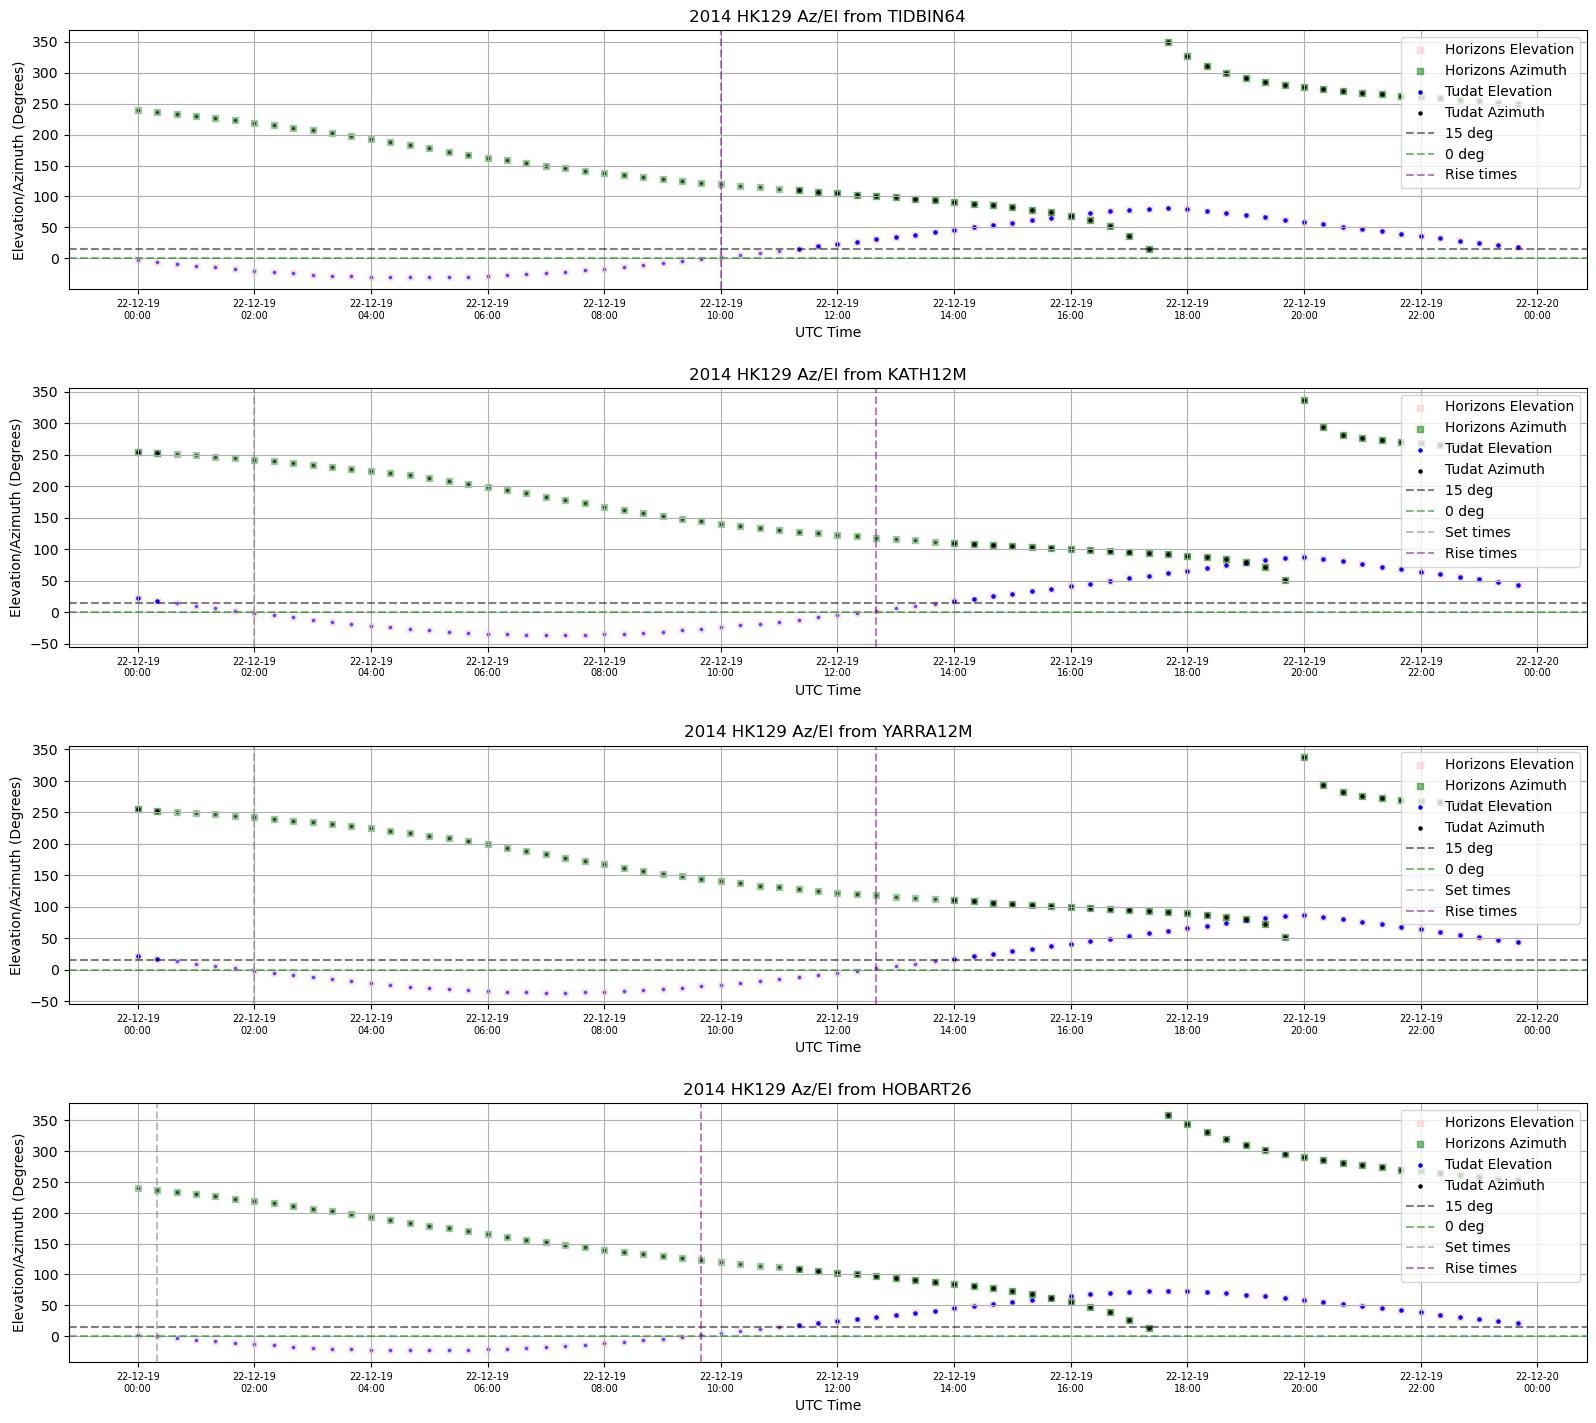

In [4]:
# Select station names
station_names =['TIDBIN64', 'KATH12M', 'YARRA12M', 'HOBART26']

# Here, we trick tudat by changing the (already defined in the tudat list of stations) position for KATH12M.
# Hence, we will expect to have the same exact plot for both Yarragadee and Katherine.
# We do this in order to show how an already-existing Tudat station location (such as the one of KATH12M) can be overwritten by the user.  
geodetic_positions = {'YARRA12M': [250,-29.0464, 115.3456], 'KATH12M': [250,-29.0464, 115.3456]}

# Select the global frame and orientation
global_frame_origin = 'Earth'
global_frame_orientation = 'J2000'

# Retrieving Horizons + Tudat Az/El plot for given start and end epochs
start_epoch = '2022-12-19 00:00:00'
end_epoch = '2022-12-20 00:00:00'

plot_combined_elevation(
    '2014 HK129',
    station_names,
    start_epoch = start_epoch,
    end_epoch = end_epoch,
    time_step= '20m',
    geodetic_positions=geodetic_positions,
    custom_ephemeris = None
)